# Testing out Deno with GeoTiff

Testing out the Deno jupyter kernel by using it to read in and render a geotiff file. The geotiff file is Sentinel-2 data taken from [Digital Earth Australia](https://maps.dea.ga.gov.au/) from somewhere on Bruny Island, Tasmania.

## Read GeoTiff Data

Reading in the file as bytes using `Deno.readFile`.
Using the `geotiff` library to parse the GeoTiff file.
The geotiff library wont actually load the bands into memory until we call readRasters.

# Testing Deno with Geotiff

In [1]:
import { fromArrayBuffer } from "npm:geotiff"
// Read all the file in
const fileBytes = await Deno.readFile("./sentinel_2_test.tiff")
const tiff = await fromArrayBuffer(fileBytes.buffer)
const image = await tiff.getImage(0)

// TODO - pretty print / format metadata
// image.fileDirectory.GDAL_METADATA


## Read in select bands

Load selected bands into the red, green and blue channels.

In [12]:
const [red, green, blue] = await image.readRasters({ samples: [5, 4, 3] })

## Setup stretch functions

I want to copy ENVI's default linear 2% stretch. This is a linear stretch that stretches the 2nd percentile to 98th percentile of the data to the 0-255 range.

In [13]:
import { quantile } from 'npm:d3-array';
import { scaleLinear } from 'npm:d3-scale';

// // Calculate 2nd and 98th percentiles
const blue2nd = quantile(blue.filter(d => d != -999), 0.02);
const blue98th = quantile(blue.filter(d => d != -999), 0.98);
const red2nd = quantile(red.filter(d => d != -999), 0.02);
const red98th = quantile(red.filter(d => d != -999), 0.98);
const green2nd = quantile(green.filter(d => d != -999), 0.02);
const green98th = quantile(green.filter(d => d != -999), 0.98);

// // Create new linear scales
const blueScale = scaleLinear([blue2nd, blue98th], [0, 255]).clamp(true);
const redScale = scaleLinear([red2nd, red98th], [0, 255]).clamp(true);
const greenScale = scaleLinear([green2nd, green98th], [0, 255]).clamp(true);

## Create image

Create an pixel array of the correct size and fill it with the stretched data.

In [14]:
const imageWidth = image.getWidth()
const imageHeight = image.getHeight()

// Each pixel is 4 bytes (r, g, b, a)
const pixelBytes = 4
const arrayBuffer = new ArrayBuffer(imageWidth * imageHeight * pixelBytes)
const pixels = new Uint8ClampedArray(arrayBuffer)

for (let i = 0; i < red.length; i++) {
  const pixelOffset = i * pixelBytes
  pixels[pixelOffset + 0] = redScale(red[i])     // red
  pixels[pixelOffset + 1] = greenScale(green[i]) // green
  pixels[pixelOffset + 2] = blueScale(blue[i])   // blue
  pixels[pixelOffset + 3] = 255                  // alpha
}

const imageData = new ImageData(pixels, imageWidth, imageHeight);
imageData

ImageData {
  data: Uint8ClampedArray(15270528) [
    1, 1, 4, 255, 1, 1, 4, 255, 0, 0, 5, 255,
    0, 0, 1, 255, 0, 1, 1, 255, 0, 1, 1, 255,
    0, 1, 2, 255, 1, 2, 2, 255, 1, 2, 2, 255,
    1, 2, 2, 255, 0, 0, 4, 255, 0, 0, 2, 255,
    0, 0, 2, 255, 0, 0, 1, 255, 0, 0, 1, 255,
    0, 1, 2, 255, 0, 1, 2, 255, 0, 1, 1, 255,
    0, 2, 3, 255, 0, 2, 3, 255, 0, 2, 2, 255,
    0, 1, 2, 255, 0, 1, 2, 255, 0, 1, 2, 255,
    0, 1, 2, 255,
    ... 15270428 more items
  ],
  width: 2093,
  height: 1824,
  colorSpace: "srgb"
}

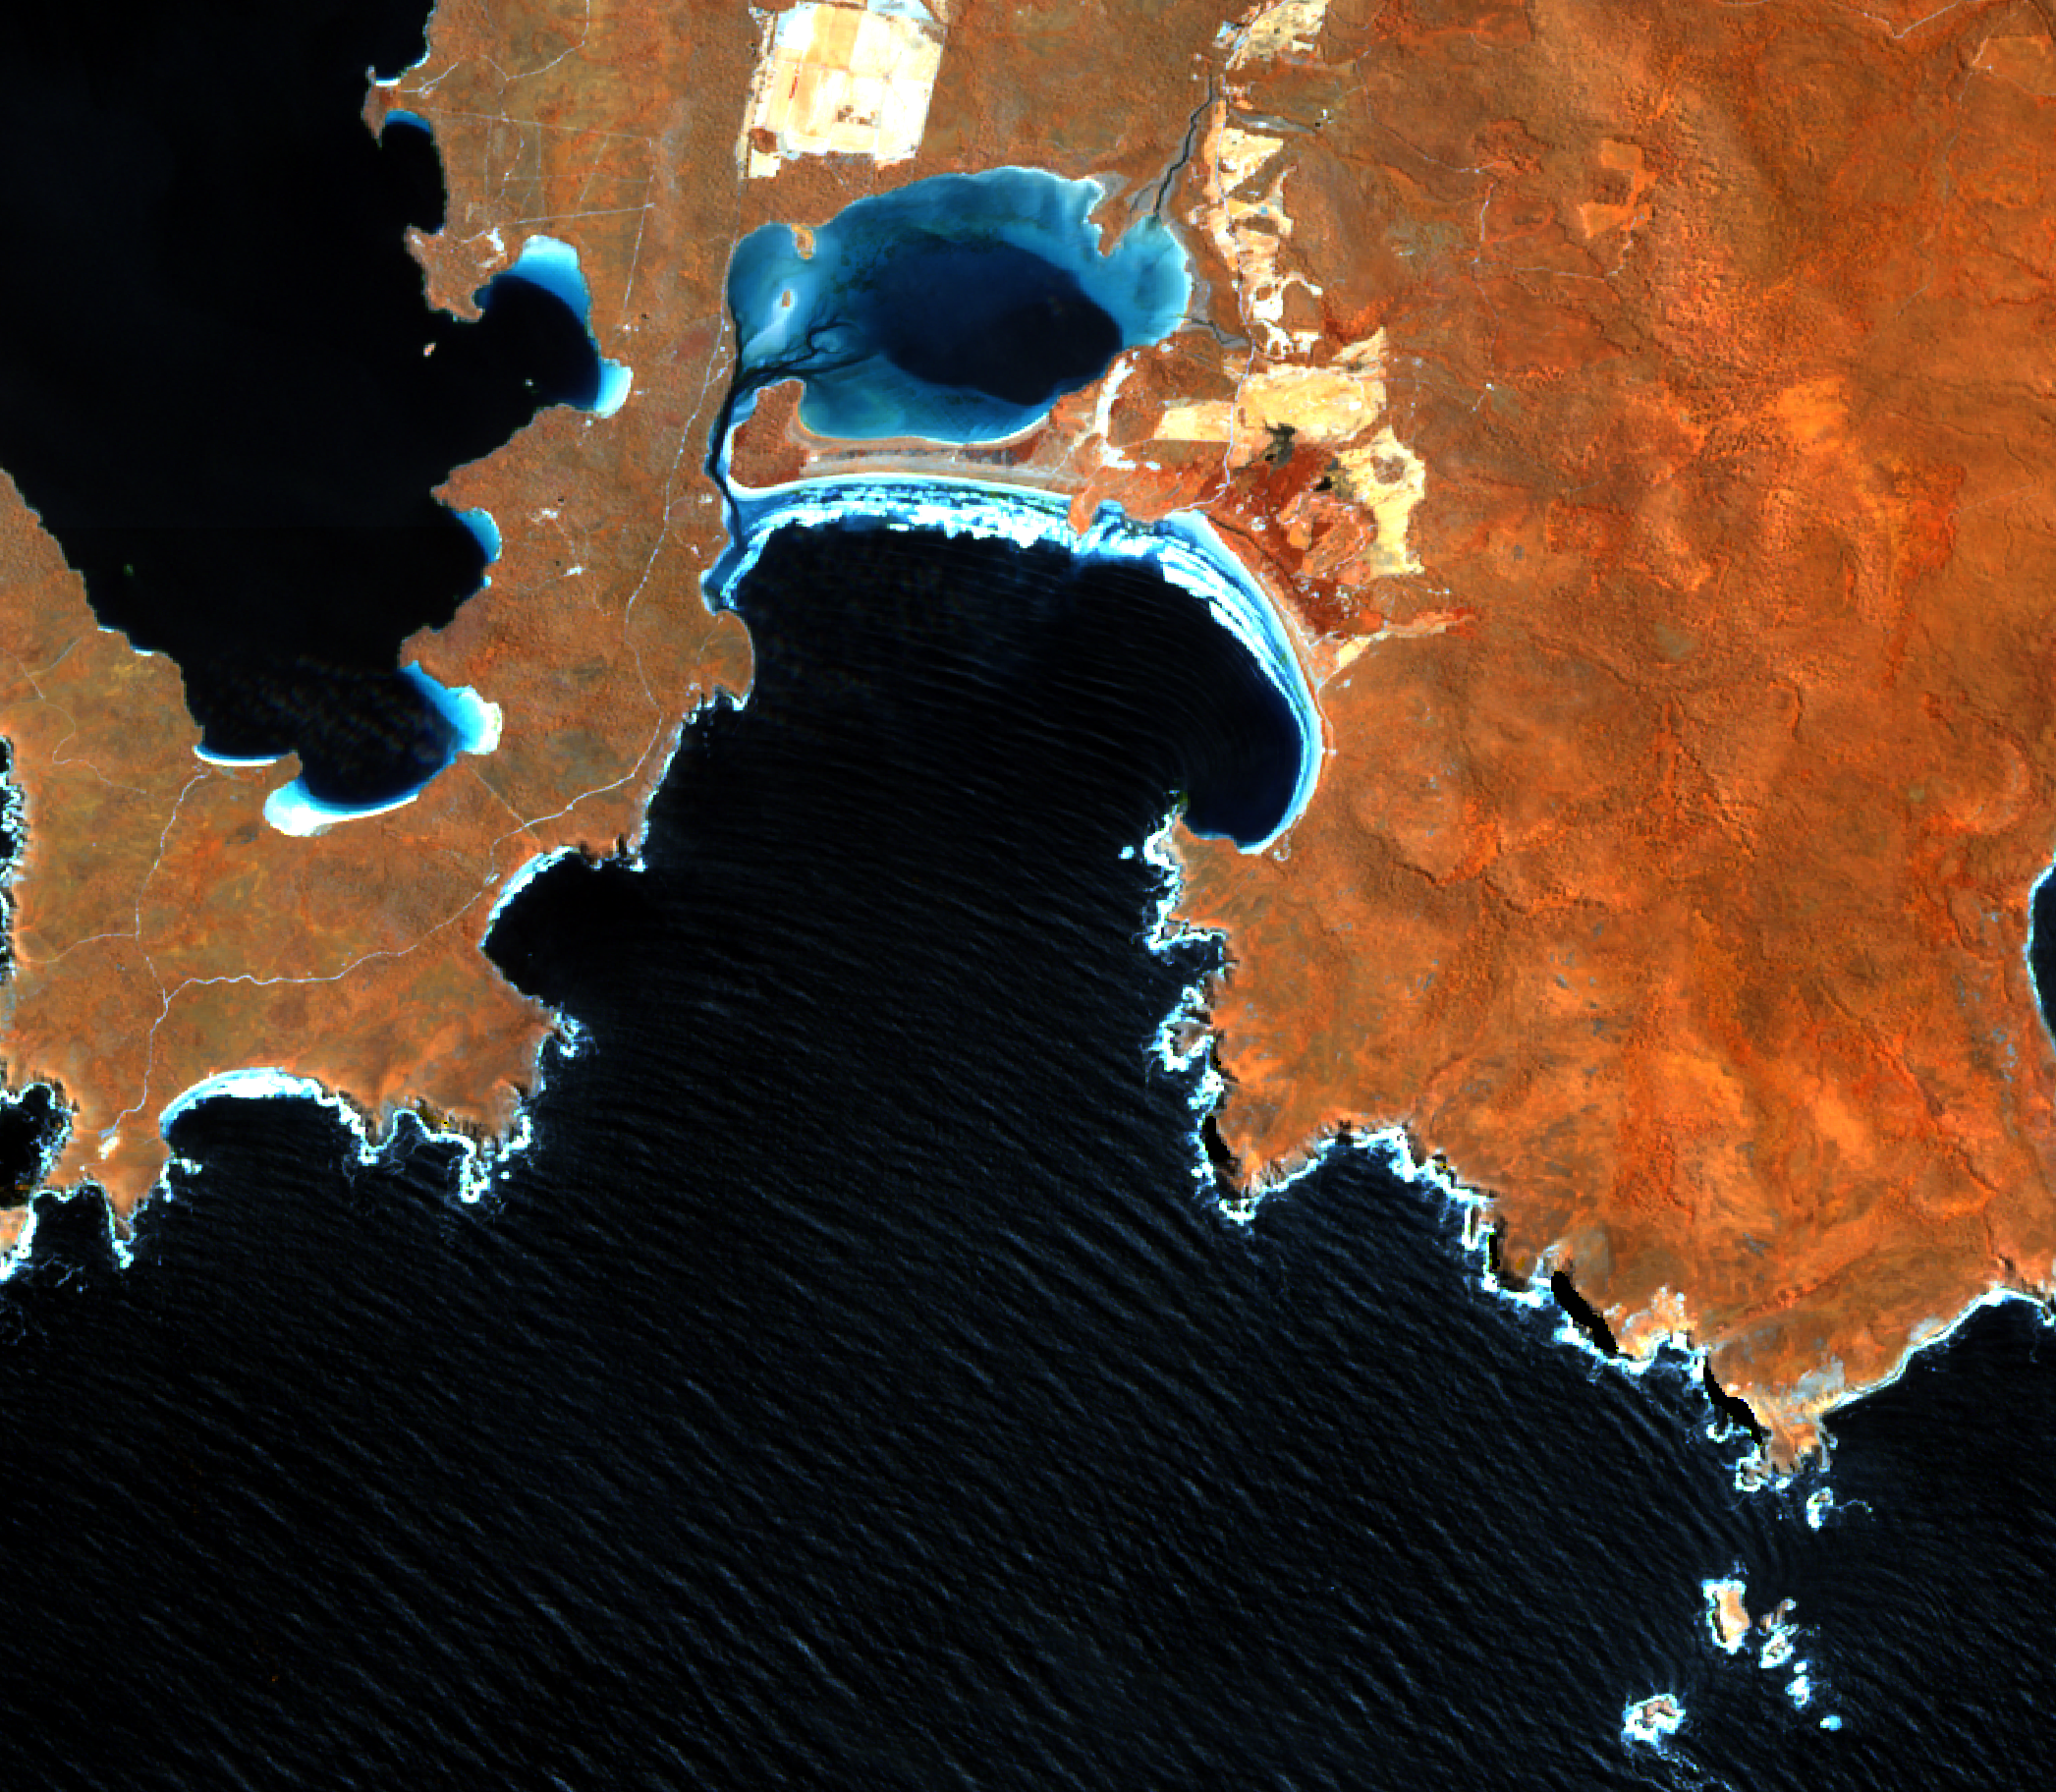

In [15]:
// This often stalls in VSCode for whatever reason 😔
import { createCanvas } from 'jsr:@gfx/canvas'
const canvas : HTMLCanvasElement = createCanvas(imageWidth, imageHeight)
const ctx = canvas.getContext('2d')!

ctx.putImageData(imageData, 0, 0)

canvas